# Statistical methods in AI

## Assignment 2

### Problem 2:
### GMM: Gaussian Mixture Model

This part of the assignment requires us to code the EM algorithm which helps in clustering of data points. This is done by finding the appropriate parameters of the GMM which fits the model. Let us start by visualising the data given to us.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
data = pd.read_csv('data.csv')
data = data.drop('Index', axis = 1)
print(data.head())

   Gender  Marital status  Age  Education  Income  Occupation  Settlement size
0       0               0   67          2  124670           1                2
1       1               1   22          1  150773           1                2
2       0               0   49          1   89210           0                0
3       0               0   45          1  171565           1                1
4       0               0   53          1  149031           1                1


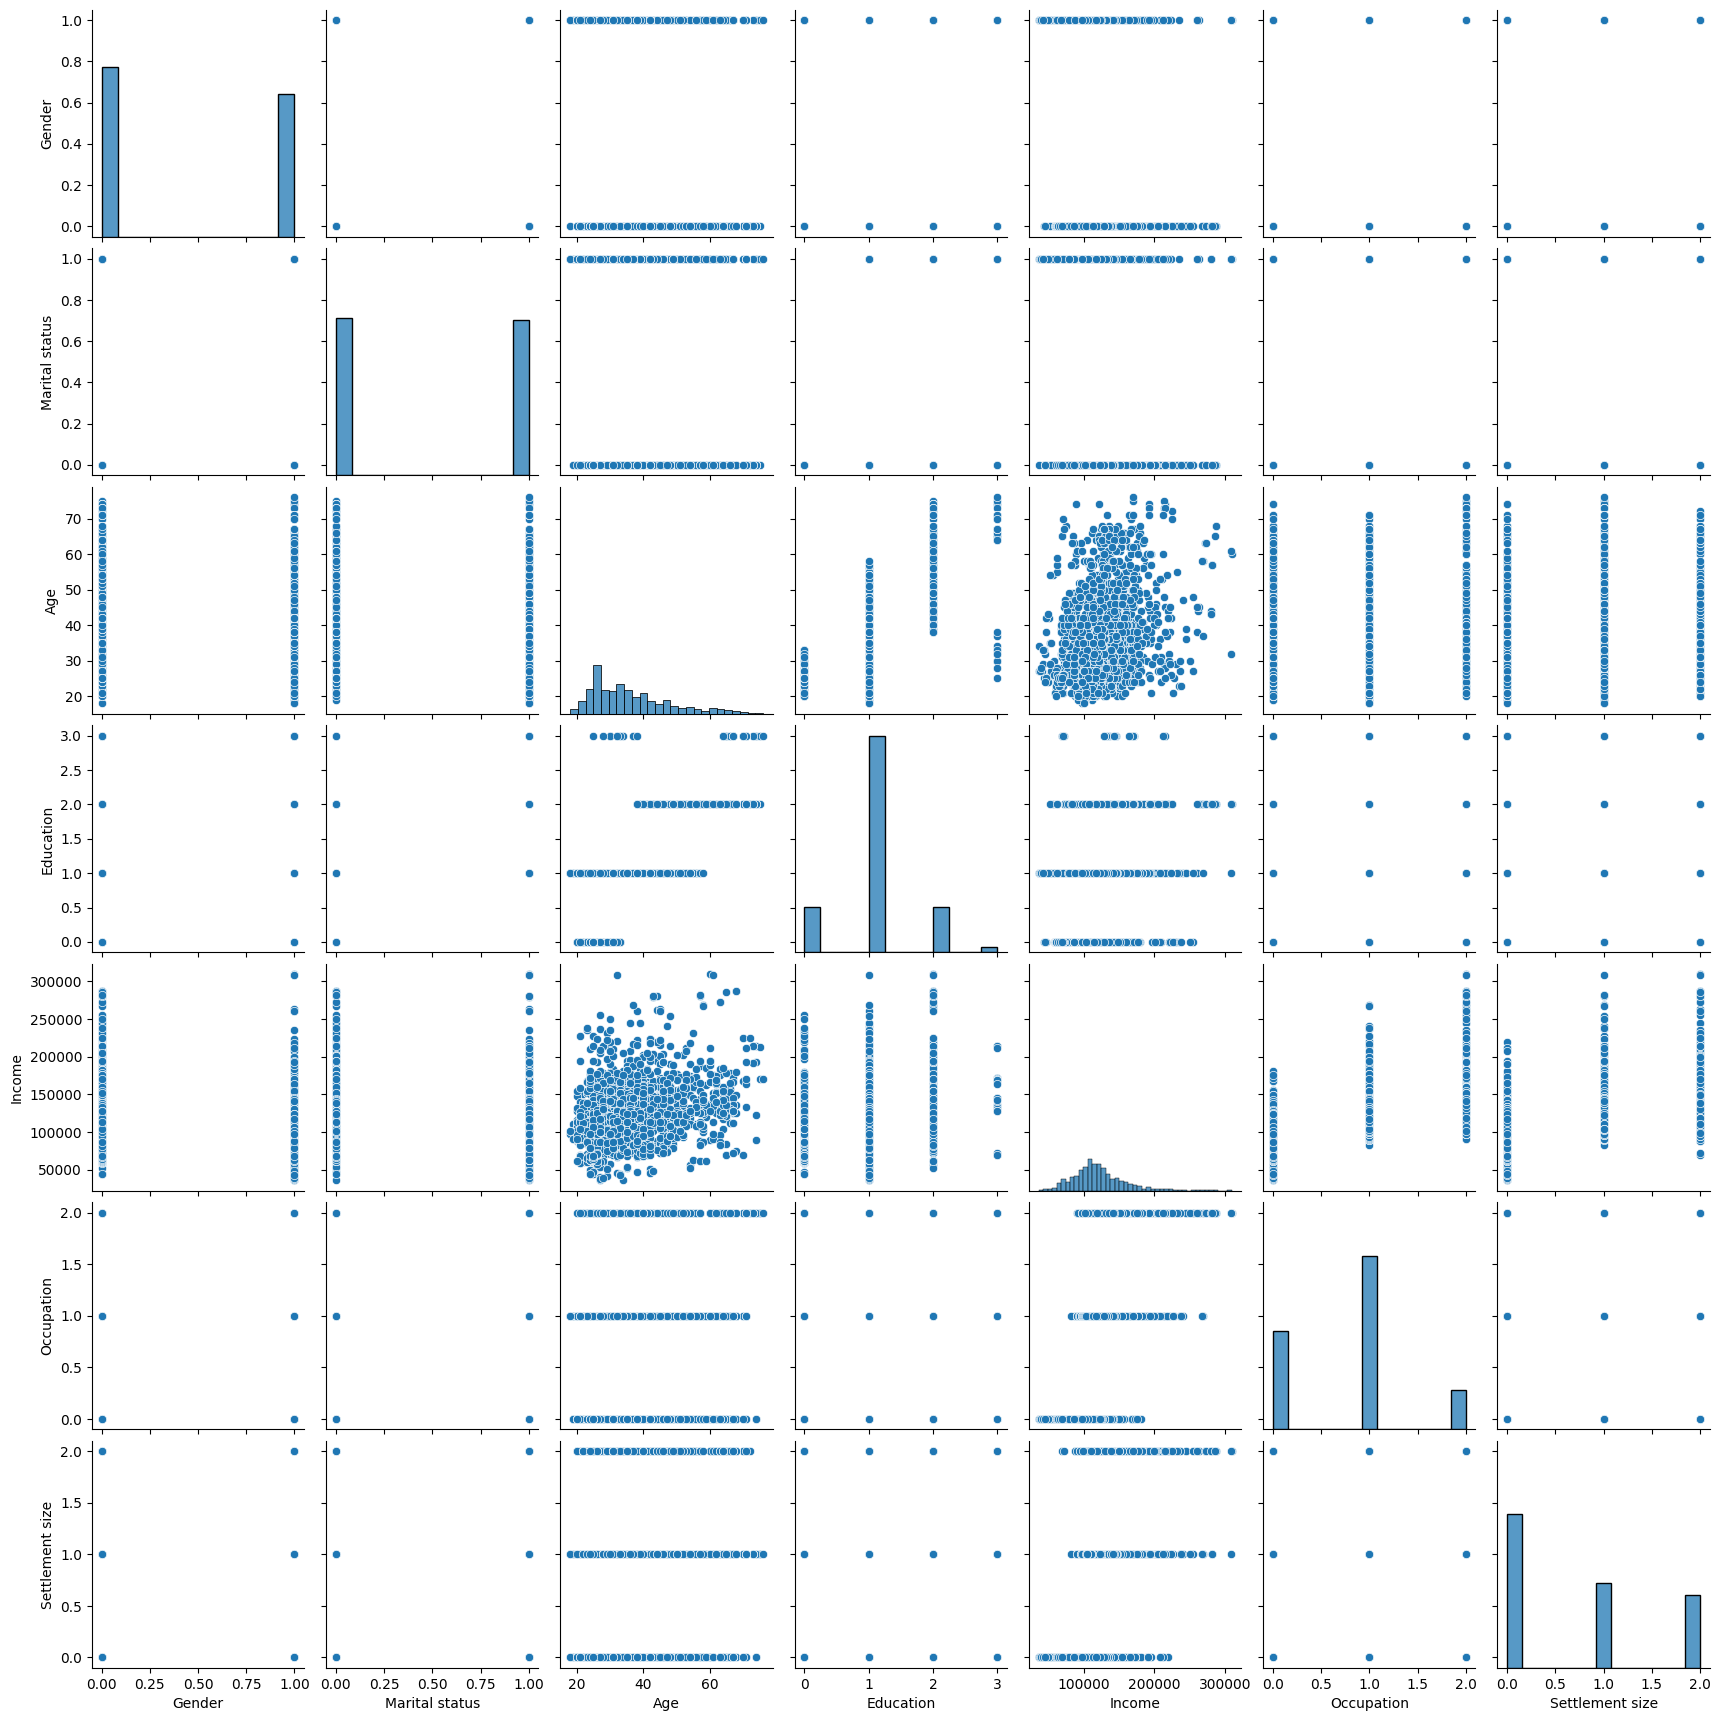

In [4]:
sns.pairplot(data)
plt.show()

Let us now make the GMM class which fill fit the data as well as predict the new parameters after every update. We will also implement the pca function inside the class as below.

In [6]:
class gmm:
    def __init__(self):
        self.mean = None
        self.covariance = None
        self.weights = None
        self.responsibility = None
        self.likelihood = None
        self.num_params = None

    def pca(self, data, n):
        pca = PCA(n_components = n)
        return pca.fit_transform(data)

    def initialisation(self, data, n_classes):
        n_samples, features = data.shape
        self.mean = np.random.rand(n_classes, features) # means of shape (n_classes, features)
        self.covariance = [np.cov(data.T)]*n_classes # covariance matrix of shape (n_classes, features, features)
        self.weights = np.random.dirichlet(np.ones(n_classes))[:, np.newaxis] # Getting a matrix of weights which has a sum of one
        self.responsibility = np.random.rand(n_classes, n_samples)
        self.likelihood = np.random.rand(n_classes, n_samples)
        self.num_params = n_classes*(2*features + 1)

    def fit(self, data, n_classes, n_iterations):
        self.initialisation(data, n_classes)

        n_samples, features = data.shape

        for _ in tqdm(range(n_iterations)):
            # E step:
            for i in range(n_classes):
                mvn = multivariate_normal(mean = self.mean[i], cov = self.covariance[i], allow_singular=True)
                self.responsibility[i] = self.weights[i]*mvn.pdf(data)  # Making the responibility matrix

            self.responsibility /= np.linalg.norm(self.responsibility, axis = 0, ord = 1, keepdims = True) # normalize the responisibilities

            gamma = np.sum(self.responsibility, axis = 1, keepdims=True) # getting the class responsibilites

            # M step:
            # Applying the results obtained from getting the derivatives

            self.weights = gamma/n_samples

            self.mean = np.dot(self.responsibility, data)/gamma

            deviation = np.tile(np.expand_dims(data, axis = 0), (n_classes, 1, 1)) - np.expand_dims(self.mean, axis = 1)
            self.covariance = np.matmul(np.expand_dims(self.responsibility, axis=1)*np.transpose(deviation,(0, 2, 1)), deviation)/np.expand_dims(gamma, axis = 2)

    def get_params(self, verbose=False):
        if verbose:
            print('------------------------------')
            print('Class Probabilities:')
            for i in range(len(self.weights)):
                print(f'Class {i}:')
                print(f'{self.weights[i]}')

            print('------------------------------')
            print('Mean of the classes')
            for i in range(len(self.mean)):
                print(f'Class {i}:')
                print(f'{self.mean[i]}')

            print('------------------------------')
            print('Covariance matrix of the classes')
            for i in range(len(self.covariance)):
                print(f'Class {i}:')
                print(f'{self.covariance[i]}') 
        
        return self.mean, self.covariance, self.weights

    def get_membership(self, data, verbose=False):
        n_classes, n_samples = self.responsibility.shape
        for i in range(n_classes):
            mvn = multivariate_normal(mean = self.mean[i], cov = self.covariance[i], allow_singular=True)
            self.responsibility[i] = self.weights[i]*mvn.pdf(data)

        if verbose:
            print('likelihoods of the given data for every sample')
            for i in range(n_samples):
                print('------------------')
                print(f'Sample number {i+1}:')
                for j in range(n_classes):
                    print(f'\t Class {j}: {self.responsibility[j, i]}')
        
        return self.responsibility

    def get_predictions(self, verbose=False):
        memberships = np.argmax(self.responsibility, axis = 0)

        if verbose:
            print('Membership for each data point is :')
            print('----------------------')
            for i in range(len(memberships)):
                print(f'Sample {i+1} : {memberships[i]}')
        
        return memberships

    def get_likelihood(self, data,verbose=False):
        n_classes, n_samples = self.responsibility.shape
        for i in range(n_classes):
            mvn = multivariate_normal(mean = self.mean[i], cov = self.covariance[i], allow_singular=True)
            self.likelihood[i] = mvn.pdf(data)*self.weights[i]

        threshold = 1e-20
        self.likelihood[self.likelihood < threshold] = threshold
        

        likelihood = np.sum(self.likelihood, axis = 0)
        likelihood = np.sum(np.log(likelihood))

        if verbose:
            print(f'likelihood is : {likelihood}')

        return likelihood




Above is the implementation of the EM algorithm. Now let us perform GMM on the data given which is reduced to 2 dimesions using PCA. This is done so that we can visualise the clusters. Below is the implementation of the GMM algorithm on the dataset.

100%|██████████| 100/100 [00:00<00:00, 794.46it/s]


------------------------------
Class Probabilities:
Class 0:
[0.52004814]
Class 1:
[0.07925293]
Class 2:
[0.40069893]
------------------------------
Mean of the classes
Class 0:
[-9.59547041e+03 -6.46937420e+00]
Class 1:
[ 7.78860729e+04 -1.96956825e+00]
Class 2:
[-2951.32515521     8.78584848]
------------------------------
Covariance matrix of the classes
Class 0:
[[ 7.40643903e+08 -3.43046421e+04]
 [-3.43046421e+04  2.23678758e+01]]
Class 1:
[[ 2.11359761e+09 -8.24092741e+04]
 [-8.24092741e+04  1.69952303e+02]]
Class 2:
[[9.15243667e+08 3.65262001e+04]
 [3.65262001e+04 1.08315544e+02]]


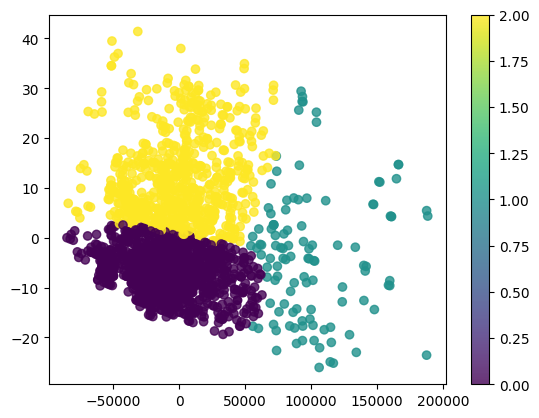

In [8]:
model = gmm()
data1 = model.pca(data, 2)
model.fit(data1, 3, 100)
pred = model.get_predictions()
model.get_params(verbose=True) # printing the parameters of the model.

plt.scatter(data1[:, 0], data1[:, 1], c = pred, alpha = 0.8)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters 3')
plt.colorbar()
plt.show()

We can see the clusters clearly which is the proof that the model fits the data properly.
Let us take a look at how the clusters look for larger number of clusters. we will be varying the number of clusters from 2 to 10.

100%|██████████| 100/100 [00:00<00:00, 1272.79it/s]


------------------------------
Class Probabilities:
Class 0:
[0.57172979]
Class 1:
[0.42827021]
------------------------------
Mean of the classes
Class 0:
[-1.33247556e+04 -5.30023300e+00]
Class 1:
[1.77882083e+04 7.07567562e+00]
------------------------------
Covariance matrix of the classes
Class 0:
[[ 6.04424310e+08 -3.27545491e+04]
 [-3.27545491e+04  3.00221065e+01]]
Class 1:
[[ 2.02901220e+09 -1.76418754e+05]
 [-1.76418754e+05  1.56068677e+02]]


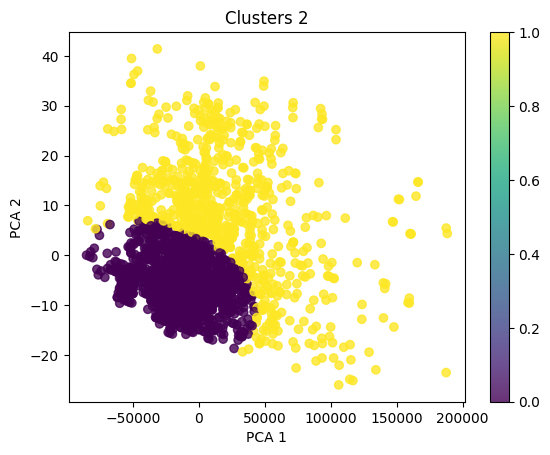

100%|██████████| 100/100 [00:00<00:00, 1152.05it/s]


------------------------------
Class Probabilities:
Class 0:
[0.48973273]
Class 1:
[0.34608017]
Class 2:
[0.1641871]
------------------------------
Mean of the classes
Class 0:
[-9.05254486e+03 -6.95295871e+00]
Class 1:
[-8.57465569e+03  6.25393310e+00]
Class 2:
[4.50756843e+04 7.55680117e+00]
------------------------------
Covariance matrix of the classes
Class 0:
[[ 7.57786495e+08 -3.46688484e+04]
 [-3.46688484e+04  1.99052958e+01]]
Class 1:
[[7.03977058e+08 3.03810863e+04]
 [3.03810863e+04 7.53400609e+01]]
Class 2:
[[ 2.66546223e+09 -3.75965134e+05]
 [-3.75965134e+05  2.38128760e+02]]


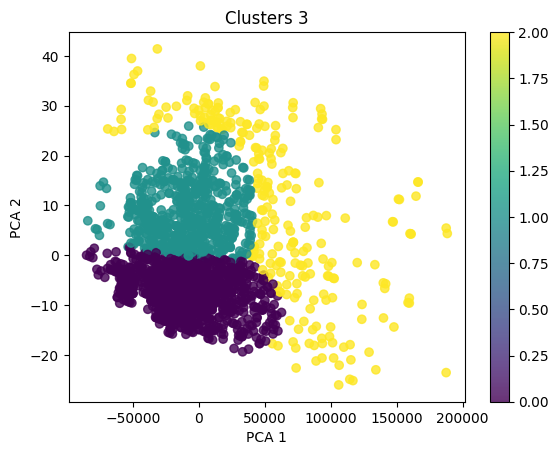

100%|██████████| 100/100 [00:00<00:00, 1007.41it/s]


------------------------------
Class Probabilities:
Class 0:
[0.19982716]
Class 1:
[0.32010564]
Class 2:
[0.35321292]
Class 3:
[0.12685428]
------------------------------
Mean of the classes
Class 0:
[2924.40502344   12.11765111]
Class 1:
[-2.12066084e+04 -8.32230627e+00]
Class 2:
[-472.86173646   -1.56936537]
Class 3:
[5.02229824e+04 6.28202354e+00]
------------------------------
Covariance matrix of the classes
Class 0:
[[6.32998988e+08 3.48462160e+04]
 [3.48462160e+04 8.54996417e+01]]
Class 1:
[[ 5.14031798e+08 -5.23451601e+04]
 [-5.23451601e+04  1.34491129e+01]]
Class 2:
[[ 8.67500823e+08 -1.26605206e+05]
 [-1.26605206e+05  4.14926548e+01]]
Class 3:
[[ 3.06172142e+09 -3.89025611e+05]
 [-3.89025611e+05  2.21291958e+02]]


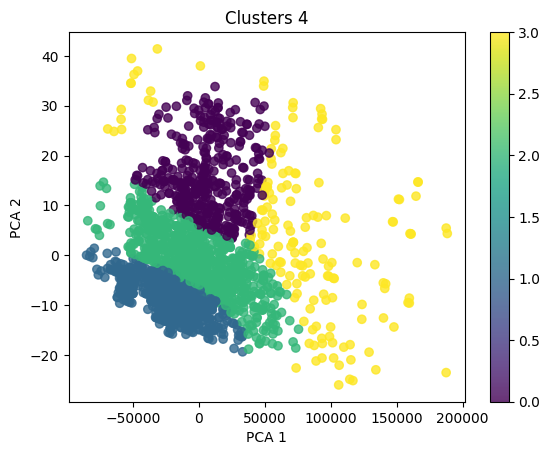

100%|██████████| 100/100 [00:00<00:00, 783.79it/s]


------------------------------
Class Probabilities:
Class 0:
[0.13690029]
Class 1:
[0.35450843]
Class 2:
[0.09376151]
Class 3:
[0.34246728]
Class 4:
[0.07236248]
------------------------------
Mean of the classes
Class 0:
[ 7.37474990e+03 -3.06903787e+00]
Class 1:
[-3193.86198179     3.28832476]
Class 2:
[14429.03282883    22.04675918]
Class 3:
[-1.93212421e+04 -8.20744435e+00]
Class 4:
[ 7.44398330e+04 -2.68510237e-02]
------------------------------
Covariance matrix of the classes
Class 0:
[[ 1.16009820e+09 -2.08548403e+05]
 [-2.08548403e+05  4.63181299e+01]]
Class 1:
[[ 7.43282867e+08 -4.04731916e+04]
 [-4.04731916e+04  5.75676826e+01]]
Class 2:
[[ 1.03039266e+09 -6.05081634e+04]
 [-6.05081634e+04  5.25499192e+01]]
Class 3:
[[ 5.45019684e+08 -5.32966855e+04]
 [-5.32966855e+04  1.41845232e+01]]
Class 4:
[[ 2.57820470e+09 -1.42948132e+05]
 [-1.42948132e+05  1.54871455e+02]]


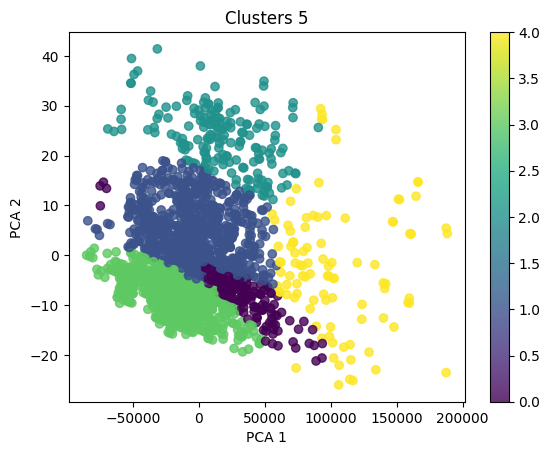

100%|██████████| 100/100 [00:00<00:00, 630.83it/s]


------------------------------
Class Probabilities:
Class 0:
[0.3020779]
Class 1:
[0.0476156]
Class 2:
[0.21287567]
Class 3:
[0.21267428]
Class 4:
[0.0206963]
Class 5:
[0.20406025]
------------------------------
Mean of the classes
Class 0:
[-2.26080492e+04 -8.36758945e+00]
Class 1:
[-2641.21991649    11.35175275]
Class 2:
[1.81113982e+04 1.37123055e+01]
Class 3:
[-1.24368771e+04 -5.28294414e-01]
Class 4:
[ 1.33295362e+05 -6.52851942e+00]
Class 5:
[ 1.46327474e+04 -3.35392073e+00]
------------------------------
Covariance matrix of the classes
Class 0:
[[ 5.05784515e+08 -5.44141364e+04]
 [-5.44141364e+04  1.34091993e+01]]
Class 1:
[[ 1.47797152e+08 -2.07270774e+04]
 [-2.07270774e+04  1.32346284e+01]]
Class 2:
[[ 1.22201529e+09 -8.04093680e+04]
 [-8.04093680e+04  1.19426332e+02]]
Class 3:
[[ 4.58505864e+08 -9.09156031e+04]
 [-9.09156031e+04  3.72548906e+01]]
Class 4:
[[8.81162946e+08 1.72127857e+05]
 [1.72127857e+05 1.41428778e+02]]
Class 5:
[[ 1.21029676e+09 -1.55068104e+05]
 [-1.55068

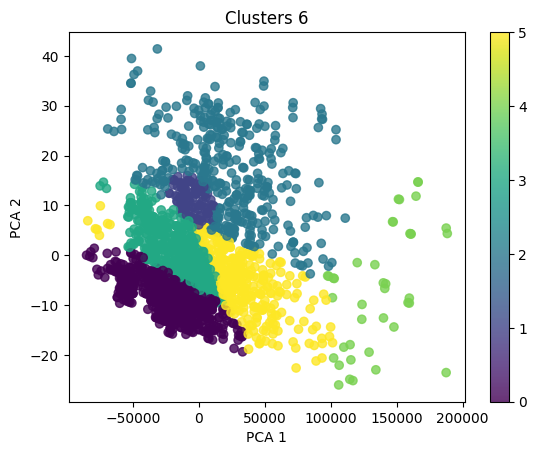

100%|██████████| 100/100 [00:00<00:00, 585.20it/s]


------------------------------
Class Probabilities:
Class 0:
[0.12514852]
Class 1:
[0.06458223]
Class 2:
[0.09535683]
Class 3:
[0.21769877]
Class 4:
[0.31342057]
Class 5:
[0.09556742]
Class 6:
[0.08822566]
------------------------------
Mean of the classes
Class 0:
[-1.96112259e+04 -7.56695041e+00]
Class 1:
[5.95193172e+04 1.17174200e+01]
Class 2:
[ 3.77655135e+04 -2.70437303e+00]
Class 3:
[4015.71925565   12.03287869]
Class 4:
[-4.85347763e+03 -1.75120515e+00]
Class 5:
[-1.39015594e+04 -8.87640185e+00]
Class 6:
[-3.41768518e+04 -8.77577368e+00]
------------------------------
Covariance matrix of the classes
Class 0:
[[ 6.42933345e+08 -7.79144937e+04]
 [-7.79144937e+04  1.50149097e+01]]
Class 1:
[[ 3.84545415e+09 -4.87171242e+05]
 [-4.87171242e+05  1.92923862e+02]]
Class 2:
[[ 1.52810440e+09 -2.91673037e+05]
 [-2.91673037e+05  9.70166457e+01]]
Class 3:
[[7.16014468e+08 2.85306454e+04]
 [2.85306454e+04 9.10269982e+01]]
Class 4:
[[ 7.08327003e+08 -1.15163930e+05]
 [-1.15163930e+05  3.970

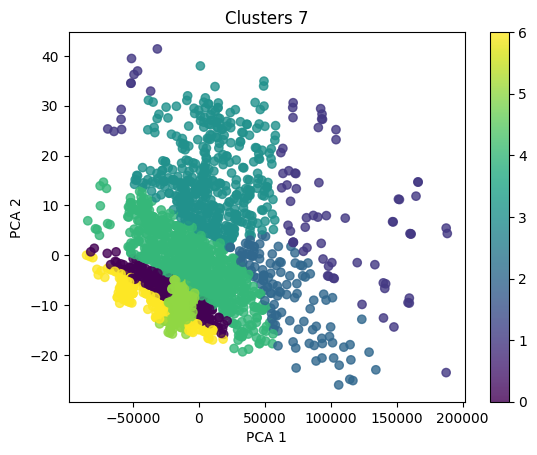

100%|██████████| 100/100 [00:00<00:00, 526.21it/s]


------------------------------
Class Probabilities:
Class 0:
[0.02468794]
Class 1:
[0.07933627]
Class 2:
[0.18887391]
Class 3:
[0.14431327]
Class 4:
[0.16863732]
Class 5:
[0.0380446]
Class 6:
[0.04667267]
Class 7:
[0.30943402]
------------------------------
Mean of the classes
Class 0:
[ 1.26773453e+05 -7.94258788e+00]
Class 1:
[-1.90681808e+04 -8.88976900e+00]
Class 2:
[-1.44125243e+04 -8.63951713e+00]
Class 3:
[-5520.7575115      8.08290838]
Class 4:
[2.25820849e+04 1.53946615e+01]
Class 5:
[-5.45224251e+04 -5.97624589e+00]
Class 6:
[-2.40793698e+04  4.23509892e+00]
Class 7:
[ 4.17485409e+03 -3.87720232e+00]
------------------------------
Covariance matrix of the classes
Class 0:
[[9.95214555e+08 1.84516324e+05]
 [1.84516324e+05 1.36119354e+02]]
Class 1:
[[ 9.17364217e+08 -1.23519580e+05]
 [-1.23519580e+05  2.07103762e+01]]
Class 2:
[[ 1.37356877e+08 -6.16233984e+03]
 [-6.16233984e+03  1.10755496e+01]]
Class 3:
[[ 4.72144227e+08 -1.92560041e+04]
 [-1.92560041e+04  3.68326635e+01]]
Cl

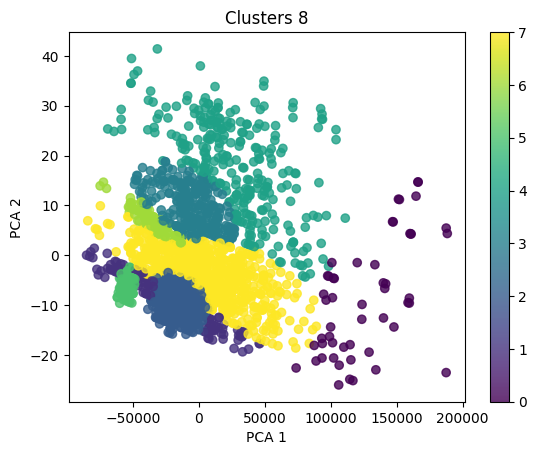

100%|██████████| 100/100 [00:00<00:00, 435.44it/s]


------------------------------
Class Probabilities:
Class 0:
[0.07863272]
Class 1:
[0.19305718]
Class 2:
[0.10199328]
Class 3:
[0.06104991]
Class 4:
[0.12066971]
Class 5:
[0.13135602]
Class 6:
[0.01575533]
Class 7:
[0.14343605]
Class 8:
[0.15404981]
------------------------------
Mean of the classes
Class 0:
[ 2.55778931e+04 -1.89590259e+00]
Class 1:
[-2.67611674e+04 -8.32240396e+00]
Class 2:
[ 1.65311243e+04 -8.36503969e+00]
Class 3:
[5.62294042e+04 1.26019981e+01]
Class 4:
[-9.53691914e+03  6.44267012e-01]
Class 5:
[691.31989593   3.79020283]
Class 6:
[4326.54094104   17.43228505]
Class 7:
[-1.19123949e+04 -7.78272499e+00]
Class 8:
[4783.01108991   13.66875557]
------------------------------
Covariance matrix of the classes
Class 0:
[[ 1.50246647e+09 -7.81273856e+04]
 [-7.81273856e+04  2.48969730e+01]]
Class 1:
[[ 6.17936445e+08 -7.25013872e+04]
 [-7.25013872e+04  1.47023743e+01]]
Class 2:
[[ 1.92383321e+09 -2.51232368e+05]
 [-2.51232368e+05  4.40434073e+01]]
Class 3:
[[ 4.14807603e+

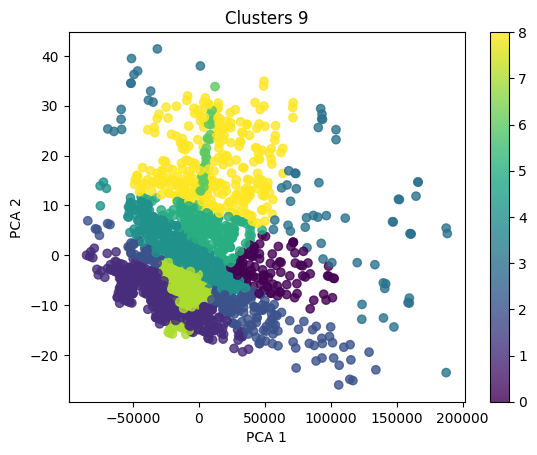

100%|██████████| 100/100 [00:00<00:00, 339.29it/s]


------------------------------
Class Probabilities:
Class 0:
[0.03386111]
Class 1:
[0.04146237]
Class 2:
[0.24511302]
Class 3:
[0.267732]
Class 4:
[0.08268333]
Class 5:
[0.01961464]
Class 6:
[0.00982646]
Class 7:
[0.12211272]
Class 8:
[0.12718282]
Class 9:
[0.05041154]
------------------------------
Mean of the classes
Class 0:
[-2.65309721e+04  5.14497155e+00]
Class 1:
[ 4.94601817e+04 -1.42027706e+01]
Class 2:
[-374.01746227   -4.03587114]
Class 3:
[-2.20093943e+04 -8.80845700e+00]
Class 4:
[ 2.40589307e+04 -9.74897026e-01]
Class 5:
[3966.54918978   16.69926677]
Class 6:
[1.55650068e+05 1.45811549e+00]
Class 7:
[2.13674705e+04 1.90419284e+01]
Class 8:
[-1261.90921612     8.7018907 ]
Class 9:
[-2.40695536e+04  1.36780768e+00]
------------------------------
Covariance matrix of the classes
Class 0:
[[ 4.27747422e+08 -8.25350242e+04]
 [-8.25350242e+04  1.74982057e+01]]
Class 1:
[[ 2.04139002e+09 -1.86072419e+05]
 [-1.86072419e+05  2.61949236e+01]]
Class 2:
[[ 6.66468142e+08 -4.77447036e

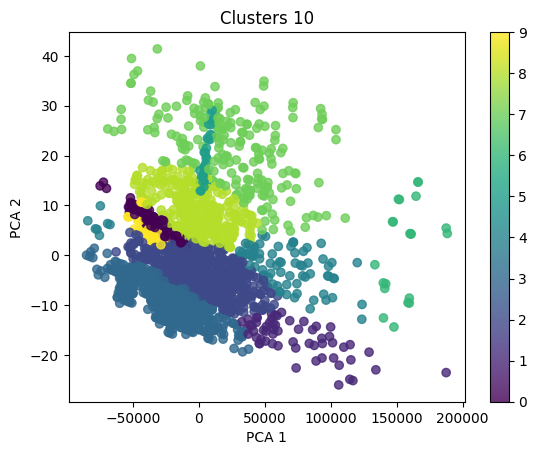

In [9]:
for i in range(2, 11):
    model.fit(data1, i, 100)
    pred = model.get_predictions()
    model.get_params(verbose=True) # printing the parameters of the model.

    plt.scatter(data1[:, 0], data1[:, 1], c = pred, alpha = 0.8)
    plt.colorbar()
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title(f'Clusters {i}')
    plt.show()

We can see that as the number of clusters increase, the model performs poorly and starts to fit to overlapping clusters. It is hence better to keep the number of clusters as low as possible.

Now let us implement our GMM model as well as the k-means algorithm on the wine dataset from the sklearn. Let us start by loading the datset and have a look inside the dataset.

In [270]:
wine_data, wine_target = load_wine(return_X_y=True, as_frame=True)
print(wine_data.head()) # The data of the wine dataset

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                  

Let us use to PCA to reduce its components to 2 and plot the scatter plot for the same.

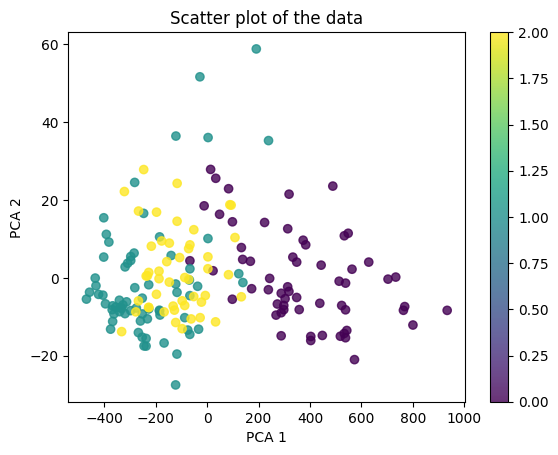

In [271]:
model = gmm()
wine_data_2 = model.pca(wine_data, 2)

plt.scatter(wine_data_2[:, 0], wine_data_2[:, 1], c = wine_target, alpha = 0.8)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Scatter plot of the data')
plt.show()


Now we will implement our GMM model for clustering as well as the sklearns k-means algorithm for clustering. Before that, we need to find the suitable value of k for which our model will give good cluster values.

In [332]:
k = 10

bic = []

for i in range(2, k):
    model.fit(wine_data_2, i, 100)
    likelihood = model.get_likelihood(wine_data_2)
    value = -2*likelihood + model.num_params*np.log(wine_data_2.shape[0]) #Getting bic values for all k values
    bic.append(value)
        

aic = []

for i in range(2, k):
    model.fit(wine_data_2, i, 100)
    likelihood = model.get_likelihood(wine_data_2)
    value = -2*likelihood + 2*model.num_params #Getting aic values for all k values
    aic.append(value)


100%|██████████| 100/100 [00:00<00:00, 661.11it/s]


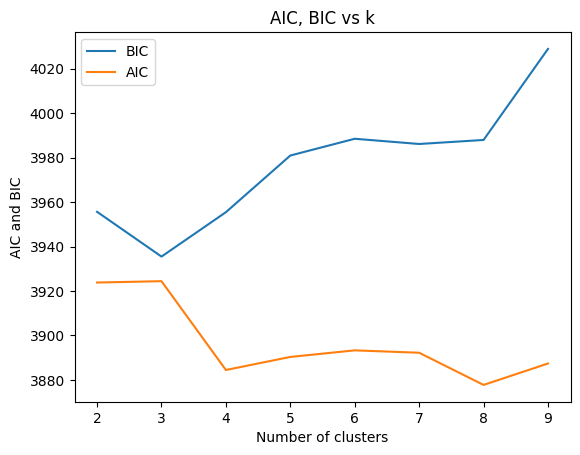

In [333]:
plt.plot(range(2, k), bic, label = 'BIC')
plt.plot(range(2, k), aic, label = 'AIC')
plt.xlabel('Number of clusters')
plt.ylabel('AIC and BIC')
plt.title('AIC, BIC vs k')
plt.legend()
plt.show()

The AIC and BIC are chosen by choosing the point at which the tradeoff begins. In this case as we can see, the AIC plot moves downward for k = 3 while it moves up for BIC. SInce 3 gives us the most optimum number of clusters for the best fit, let us implement the 2 clustering methods with k = 3

100%|██████████| 100/100 [00:00<00:00, 2430.31it/s]

silhouette score: 0.20451661438264554


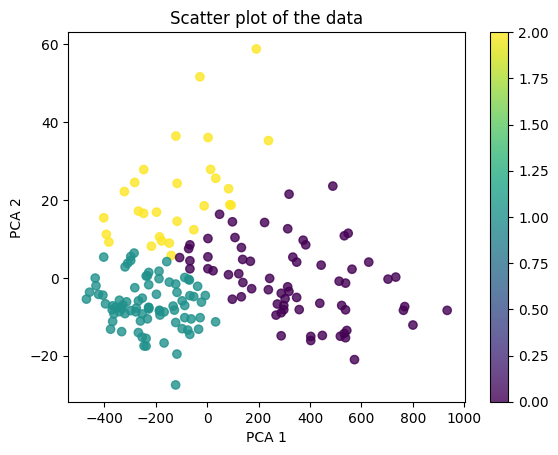

In [341]:
# GMM clustering
model.fit(wine_data_2, 3, 100)
pred = model.get_predictions()
silhouette = silhouette_score(wine_data_2, pred)
print(f'silhouette score: {silhouette}')

plt.scatter(wine_data_2[:, 0], wine_data_2[:, 1], c = pred ,alpha = 0.8)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Scatter plot of the data')
plt.show()

Now let us observe clustering using k-means.

silhouette score: 0.5602652844394509


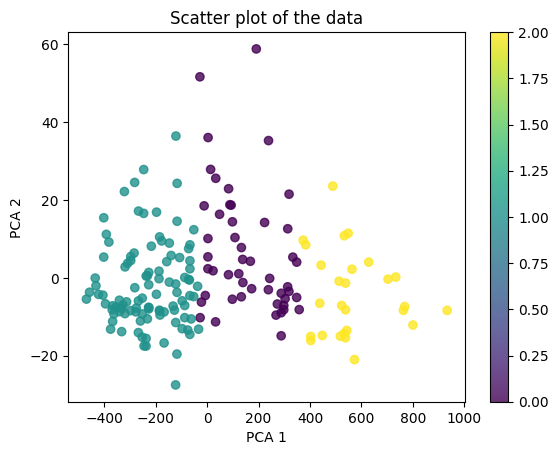

In [342]:
# KMeans clustering
kmeans = KMeans(n_clusters = 3, n_init = 'auto').fit(wine_data_2)
silhouette = silhouette_score(wine_data_2, kmeans.labels_)
print(f'silhouette score: {silhouette}')

plt.scatter(wine_data_2[:, 0], wine_data_2[:, 1], c = kmeans.labels_ ,alpha = 0.8)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Scatter plot of the data')
plt.show()

Above 2 plots are the clusters formed using GMM and k-means respectively. We can see a pretty clear distinction in terms of how the clusters are formed. For GMM, we can see that the clusters are formed in a circle like grouping while for k-means, the clusters seem to be formed in a column manner.

From the silhouette score tho, we can see that the kmeans method implemented by sklearn gives more clear and apparant clusters than that of the GMM method.